In [1]:
# load packages
using RData, LowRankApprox, DataFrames, Gadfly, Distributions, PyPlot
# load data and label
data = load("../data/1kgdata.rds");
label = Array(readtable("../data/label.1kg.txt", separator = ' ', header = false))[:];

In [132]:
# we subsample SNPs by taking 1,21,41,...th in order.
G = copy(data["X"]);
n,p = size(G);

# get label and enumerate it
unique_label = unique(label);
W = zeros(n,length(unique_label));
for i = 1:length(unique_label)
    ind = find(label .== unique_label[i]);
    W[ind,i] = 1;
end

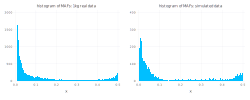

In [354]:
function sample_π(n,r; scenario = 1, σ2 = 0.5, mixture_proportion = [5;4;1])
    if scenario == 1
        π_true = pdf.(Normal.((1:r)',σ2),linspace(0,r+1,n)) +
        pdf.(Normal.((r+1:2*r)',σ2),linspace(0,r+1,n)) +
        pdf.(Normal.((-r+1:0)',σ2),linspace(0,r+1,n));
        π_true = π_true ./ sum(π_true,2);
    end
    
    if scenario == 2
        α1 = ones(r) * 0.1;
        α2 = ones(r) * 0.5;
        α3 = ones(r) * 1;
        π_true = [rand.(Dirichlet(α1),Int(n/10) * mixture_proportion[1])';
                 rand.(Dirichlet(α2),Int(n/10) * mixture_proportion[2])';
                 rand.(Dirichlet(α3),Int(n/10) * mixture_proportion[3])']
    end
    
    if scenario == 3
        π_true = [rand.(Dirichlet([10;1;0.1]),Int(n/10) * mixture_proportion[1])';
                 rand.(Dirichlet([2;1;0.5]),Int(n/10) * mixture_proportion[2])';
                 rand.(Dirichlet([1;1;1]),Int(n/10) * mixture_proportion[3])']
        
    end
    
    if scenario == 4
        π_true = [rand.(Dirichlet([0.1;0.5;0.1]),Int(n/10) * mixture_proportion[1])';
                 rand.(Dirichlet([0.5;0.1;0.1]),Int(n/10) * mixture_proportion[2])';
                 rand.(Dirichlet([1;1;1]),Int(n/10) * mixture_proportion[3])']
        
    end
    
    return π_true
end

function sample_μ(r,p; mixture_proportion = [4;3;1;1;1])
    
    num = Int(p/10) * mixture_proportion
    
    μ = [rand.(Beta.(1,100), num[1], r);
        rand.(Beta.(1,20), num[2], r);
        rand.(Beta.(1,1), num[3], r);
        rand.(Beta.(10,10), num[4], r);
        rand.(Beta.(100,100), num[5], r);]
    
    return μ'
end
        
n = 1000; r = 3; p = 4000;
srand(1)
π_true = sample_π(n,r; scenario = 3, mixture_proportion = [4;4;2]);
μ_true = sample_μ(r,p; mixture_proportion = [3;4;2;0;1]);
η_true = π_true * μ_true;
f_true = [rand.(Beta.(1,5),1,Int(p/2)) rand.(Beta.(1,10),1,Int(p/2))]
X = zeros(n,p); temp = rand(n,p);
X[temp .< (1-f_true).*η_true.^2 + f_true.*η_true + 2*(1-f_true).*η_true.*(1-η_true)] = 1;
X[temp .< (1-f_true).*η_true.^2 + f_true.*η_true] = 2;
maf = mean(X,1)/2;
maf[maf .> 0.5] = 1 - maf[maf .> 0.5];
set_default_plot_size(25cm,10cm)
F1 = Gadfly.plot(x = mean(G,1)/2, Geom.histogram, Guide.title("histogram of MAFs: 1kg real data"));
F2 = Gadfly.plot(x = maf, Geom.histogram, Guide.title("histogram of MAFs: simulated data"));
hstack(F1,F2)

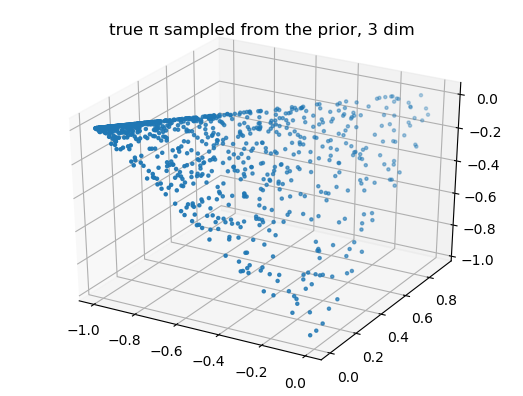

PyObject Text(0.5,0.92,u'true \u03c0 sampled from the prior, 3 dim')

In [283]:
PyPlot.scatter3D(-π_true[:,1],π_true[:,2],-π_true[:,3], s = 5)
PyPlot.title("true π sampled from the prior, 3 dim")

In [355]:
nonzeroind = find(maf .!= 0);
X2 = X[:,nonzeroind]
n2,p2 = size(X2)

# initialize
srand(1);
A = rand(n2,r); B = rand(p2,r);
for i = 1:100
    B = B .* ((X2 ./ (A*B'))' * A) ./ (sum(A,1) + 1)
    A = A .* ((X2 ./ (A*B')) * B) ./ (sum(B,1) + 1)
end

We seek to maximize

$$
\int q_\pi(\pi)q_\mu(\mu) \log \frac{p(X|\pi,\mu,\tau)p(\pi|\phi)p(\mu|\psi)}{q_\pi(\pi)q_\mu(\mu)}d\pi d\mu
$$

where 

$$
\log p(X|\pi,\mu,\tau) = a(X,\tau) + \sum_{i,j} \tau_{ij} \left[ X_{ij} \log  \sum_{l=1}^r \pi_{il} \mu_{lj} + (2-X_{ij}) \log \left(1- \sum_{l=1}^r \pi_{il} \mu_{lj}\right)  \right]\\
p(\pi|\phi,t) = \sum_{k=1}^m \phi_k p(\pi|t_k) \qquad \qquad \qquad \qquad\qquad \qquad\qquad \qquad\ \ \\
\log p(\pi_{i}|t_k) = t_k \sum_{l=1}^r \log \pi_{il} + b(t_k) \qquad \qquad \qquad \qquad\qquad \qquad\qquad \quad\ \\
p(\mu|\psi,t') = \sum_{k=1}^m \psi_k p(\mu|\nu_k,t_k') \qquad \qquad \qquad \qquad\qquad \qquad\qquad \qquad \\
\log p(\mu|\nu_k,t_k') =t_k' \nu_k  \log \mu_k + t_k' (2- \nu_k)  \log \mu_k + h(\nu_k,t_k') \qquad \qquad \qquad \qquad\quad 
$$

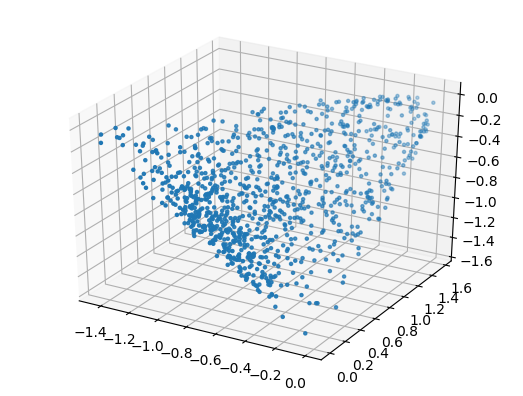

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x1857690d0>

In [364]:
PyPlot.scatter3D(-π[:,1],π[:,2],-π[:,3], s = 5)

In [573]:
# for mathematical derivation, see the note below.

include("../src/ASH_functions.jl"); include("../src/mixsqp.jl")

function update_π(X, π, μ, τ; t = 1.5.^(-(1:20) + 1) - 1)
    
    # construct Y
    η = π * μ;
    η[η .> 0.5] = 1 - η[η .> 0.5];
    Y = π .* ((X .* τ ./ η) * μ' + ((2 - X) .* τ ./ (1 - η)) * (1-μ)')
    
    # solve empirical Bayes normal means problem
    out = ash_dirichlet(Y,h_diff_dirichlet; t = t)
    
    return out[:pm]
end


function update_μ(X, π, μ, τ; ν = [zeros(7);ones(5)], t = [5.0.^(-3:3);5.0.^(-2:2)])
    
    # construct ξ and Y
    η = π * μ;
    ξ = (1 - μ) .* (π' * (τ ./ η))
    Y = (1 - μ) .* μ ./ ξ .* (π' * (X .* τ ./ η ./ (1 - η)))
    
    # solve empirical Bayes normal means problem
    out = ash_beta_binomial(Y[:],ξ[:],h_diff_beta; ν = ν, t = t)
    
    return reshape(out[:pm],size(Y))
end

function update_μ2(X, π, μ, τ; ν = [zeros(7);ones(5)], t = [5.0.^(-3:3);5.0.^(-2:2)])
    
    # construct ξ and Y
    C = μ .* (π' * (X .* τ))
    D = (1 - μ) .* (π' * ((2 - X) .* τ))
    ξ = (C+D)/2;
    Y = C ./ ξ;
    
    # solve empirical Bayes normal means problem
    out = ash_beta_binomial(Y[:],ξ[:],h_diff_beta; ν = ν, t = t)
    
    return reshape(out[:pm],size(Y))
end

function update_τ(X, π, μ)
    
    η = π * μ;
    τ = 2 * mean(η,1) .* (1 - mean(η,1)) ./ mean((X .- 2 * η).^2,1)
    
    return τ
end

update_τ (generic function with 2 methods)

In [569]:
#π = copy(π_true); μ = copy(μ_true[:,nonzeroind]); 
π = copy(A); μ = copy(B)'; 
η = π * μ;
τ = update_τ(X2, π, μ)
#τ = ones(1,p2)
for i = 1:10
    π = update_π(X2, π, μ, τ)
    μ = update_μ2(X2, π, μ, τ)
    τ = update_τ(X2, π, μ)
end

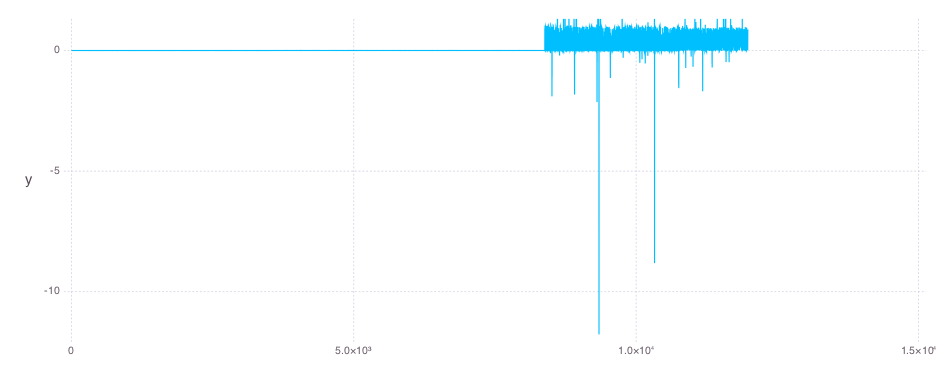

In [571]:
Gadfly.plot(y = μ, Geom.line, Coord.Cartesian(ymax = 1))

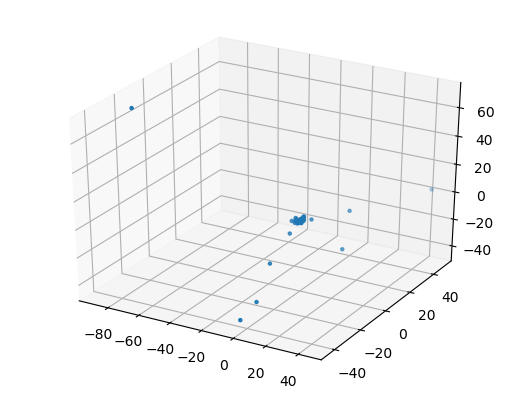

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x14244f410>

In [570]:
PyPlot.scatter3D(-π[:,1],π[:,2],-π[:,3], s = 5)

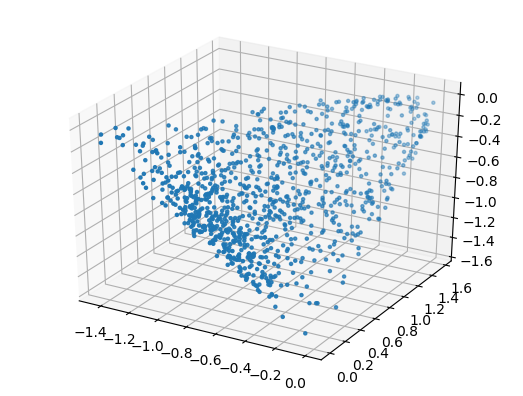

PyObject <mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x185db6d90>

In [567]:
PyPlot.scatter3D(-A[:,1],A[:,2],-A[:,3], s = 5)

In [ ]:
PyPlot.scatter3D(-π[:,1],π[:,2],-π[:,3], s = 5)

Let $P_{ij} = \sum_{l=1}^r \pi_{il} \mu_{lj}$. Then

$$
\log p(X|\pi,\mu,\tau) = C + \sum_{i,j} \tau_{ij} \left[ X_{ij} \log P_{ij} + (2-X_{ij}) \log (1-P_{ij}) \right]\\
\geq C + \sum_{i,j} \tau_{ij} \Bigg[ X_{ij} \sum_{l=1}^r A_{ijl} \log \frac{\pi_{il}\mu_{lj}}{A_{ijl}} \\
\qquad \qquad \qquad + (2-X_{ij})\sum_{l=1}^r B_{ijl} \log \frac{\pi_{il}(1-\mu_{lj})}{B_{ijl}} \Bigg]
$$

since

$$
\log \left(\sum_{l=1}^r \pi_{il}\mu_{lj} \right) \geq \sum_{l=1}^r A_{ijl} \log \frac{\pi_{il}\mu_{lj}}{A_{ijl}} \\
\log \left(1 - \sum_{l=1}^r \pi_{il}\mu_{lj} \right) \geq \sum_{l=1}^r B_{ijl} \log \frac{\pi_{il}(1-\mu_{lj})}{B_{ijl}}
$$

Here we used $\sum_l \pi_{il} = 1$. Note that the equality holds if and only if $A_{ijl} \propto \pi_{il}\mu_{lj}$ and $B_{ijl} \propto \pi_{il}(1-\mu_{lj})$

We seek to maximize

$$
\int q_\pi(\pi)q_\mu(\mu) \log \frac{p(X|\pi,\mu,\tau)p(\pi|\phi)p(\mu|\psi)}{q_\pi(\pi)q_\mu(\mu)}d\pi d\mu
$$

1. Given $q_\mu$,

$$
\textrm{maximize}\quad \int q_\pi(\pi) \mathbb{E}_{q_\mu} [\log p(X|\pi,\mu,\tau)] d\pi + \int q_\pi(\pi) \log \frac{p(\pi|\phi)}{q_\pi(\pi)} d\pi
$$

is a subproblem and its objective function is now lower bounded by

$$
\mathbb{E}_{q_\mu} [\log p(X|\pi,\mu,\tau)] \geq C' + \sum_{i,j,l} \tau_{ij} \left[ X_{ij} A_{ijl} + (2-X_{ij}) B_{ijl} \right] \log \pi_{il}
$$

2. Given $q_\pi$,

$$
\textrm{maximize}\quad \int q_\mu(\mu) \mathbb{E}_{q_\pi} [\log p(X|\pi,\mu,\tau)] d\mu + \int q_\mu(\mu) \log \frac{p(\mu|\psi)}{q_\mu(\mu)} d \mu
$$

is a subproblem and its objective function is now lower bounded by

$$
\mathbb{E}_{q_\pi} [\log p(X|\pi,\mu,\tau)] \geq C'' + \sum_{i,j,l} \tau_{ij} \left[ X_{ij} A_{ijl}\log\mu_{lj} + (2-X_{ij}) B_{ijl} \log(1-\mu_{lj}) \right]
$$

Note that 1 and 2 both enjoy conjugacy. It remains to find "best" weight vectors $A$ and $B$. We will use First-Order Taylor Coefficient Matching (FOTCM).

3-1. For the update of $\pi$, note that

$$
\pi_{il} \times \frac{\partial}{\partial \pi_{il}} \log p(X|\pi,\mu,\tau) = \pi_{il} \times \sum_j \tau_{ij} \left[ \frac{X_{ij}\mu_{lj}}{\sum_{l'}\pi_{il'} \mu_{lj} } + \frac{(2-X_{ij})(1-\mu_{lj})}{1 - \sum_{l'}\pi_{il'} \mu_{l'j} } \right]
$$

Here we have used the fact that

$$
\sum_l \pi_{il} = 1 \implies 1- \sum_{l}\pi_{il}\mu_{jl} = \sum_l \pi_{il}(1-\mu_{jl})
$$

This allows us to have always positive $Y$ which will be defined below. Note that $y$ can be called a multiplicative surrogate since it is a hadamard product of $\bar\pi$ and some weight.

Let $Y_{il}$ be the above function evaluated at $\bar\pi = \mathbb{E}_{q_\pi}\pi$ and $\bar\mu = \mathbb{E}_{q_\mu}\mu$ from previous iterations. Approximating $\log p(X|\pi,\mu,\tau)$ by

$$
C''' + \sum_{i,l} Y_{il} \log \pi_{il} 
$$
will be called FOTCM.

3-2. Or one just can use $A_{ijl} \propto \bar\pi_{il} \bar\mu_{lj}$ and $B_{ijl} \propto \bar\pi_{il} (1- \bar\mu_{lj})$ to tighten the additional lower bound where

$$
\bar\pi = \mathbb{E}_{q_\pi}\pi, \quad \bar\mu = \mathbb{E}_{q_\mu}\mu
$$

3-3. Finally, one can use

$$
A_{ijl} \propto \exp\left[\mathbb{E}_{q_\pi}\log\pi + \mathbb{E}_{q_\mu}\log\mu \right]\qquad \\
B_{ijl} \propto \exp\left[\mathbb{E}_{q_\pi}\log\pi + \mathbb{E}_{q_\mu}\log(1-\mu) \right]
$$
which is originally suggested in TeraSTRUCTURE.

4-1. For the update of $\mu$, let

$$
\xi_{lj} = (1-\mu_{lj})\sum_i \frac{\tau_{ij} \pi_{il} }{1-(\pi\mu)_{ij}}\qquad\quad\quad \\
Y_{lj} = \frac{\mu_{lj}(1-\mu_{lj})}{\xi_{lj}} \sum_i \frac{\tau_{ij}X_{ij}\pi_{il}}{(\pi\mu)_{ij}(1-(\pi\mu)_{ij})}
$$


This is obtained from comparing these two:
$$
\frac{\partial}{\partial \mu_{lj}} \log p(X|\pi,\mu,\tau) = \sum_i \tau_{ij} \left[ \frac{X_{ij}\pi_{il}}{(\pi\mu)_{ij}} - \frac{(2-X_{ij})\pi_{il}}{1 -(\pi\mu)_{ij} } \right]
$$

$$
\frac{\partial}{\partial \mu_{lj}} \langle \xi, D_G(Y\|\mu) \rangle = \frac{\xi_{lj}Y_{lj}}{\mu_{lj}} - \frac{\xi_{lj}(2-Y_{lj})}{1-\mu_{lj}}\qquad\qquad
$$

4-2. Same with 3-2.

4-3. Same with 3-3.